# Kleine Bibliothek von verschiendenen Referenztrajektoriengeneratoren (noch ohne Optimierungen)

**(2. Übung Flachheit, Aufgabe 2)**

## Aufgabenstellung

Realisiert werden soll der Übergang von $y$ von einem Wert $y_\mathrm{start}$ auf einen Wert $y_\mathrm{end}$ innerhalb des Intervalls $t_\mathrm{end} - t_\mathrm{start}$ entlang einer Referenztrajektorie $t \mapsto y_{ref}(t)$. Es sollen unterschiedliche Typen von Referenztrajektorien realisiert werden:

- Trajektorie auf Basis einer Prototypenfunktion
- Trajektorie bestimmt durch Lösung eines linearen Gleichungssystems
- Trajektorie auf Basis einer Gevrey-Funktion

Die hier vorgestellten Ansätze sind noch ohne Optimierungen (Horner Schema, Vektorisierungen...). Dies wird in Aufgabe 3 behandelt. Ebenso wurde auf Type-Annotations und umfängliche Docstrings verzichtet. Für die tanh-Trajektorie wird auch nur der skalare Ansatz implementiert, da dieser fürs Erste schon kompliziert genug ist.

---

Die aktuelle Fassung dieses Notebooks findet sich in folgendem Repositorium:

https://gitlab.hrz.tu-chemnitz.de/rst/public/teaching/flavert-nbviewer-content

**Sie können zur Entwicklung/ Verbesserung über Merge Requests beitragen!**

---

<p style="font-family:Courier New; font-size:10pt">
Copyright (c) 2023 Jan Winkler, TU Dresden, Germany
</p>

<p style="font-family:Courier New; font-size:10pt">
This program is free software: you can redistribute it and/or modify<br>
it under the terms of the GNU General Public License as published by<br>
the Free Software Foundation, either version 3 of the License, or<br>
(at your option) any later version.
</p>
    
<p style="font-family:Courier New; font-size:10pt">
This program is distributed in the hope that it will be useful,<br>
but WITHOUT ANY WARRANTY; without even the implied warranty of<br>
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br>
GNU General Public License for more details: <br>
<a href=https://www.gnu.org/licenses/gpl-3.0.txt>https://www.gnu.org/licenses/gpl-3.0.txt</a>.
</p>


---

## Import der nötigen Module

In [1]:
import numpy as np
import scipy.special as scs
import matplotlib.pyplot as plt
import abc  # für abstrakte Basisklasse

## Abstrakte Basisklasse

Diese definiert die in den abzuleitenden Methoden zu implementierenden Methoden `eval` und `eval_v`. Außerdem werden die grundlegenden Daten der Trajektorie im Konstruktor als Member-Variablen abgelegt.

In [2]:
class TrajGenBase(abc.ABC):
    """ Abstrakte Basisklasse für alle Trajektoriengeneratoren.

    Realisiert einen Übergang von einem stationären Wert y_start zu
    einem stationären Wert y_end auf dem Zeitintervall t_end - t_start.
    gamma ist ein Trajektorienspezifischer Parameter
    """

    def __init__(self, t_start, t_end, y_start, y_end, gamma):
        self.t0 = t_start
        self.t1 = t_end
        self.y0 = y_start
        self.y1 = y_end
        self.gamma = gamma

    @abc.abstractmethod
    def eval(self, t, max_deriv=-1):
        ...

    @abc.abstractmethod
    def eval_v(self, t, max_deriv=-1):
        ...

## Implementation der Trajektorie auf Prototypenbasis

Dies ist die Implementierung aus dem ersten Jupyter-Notebook zu dieser Übung. Einziger Unterschied ist, dass die Klasse nun von der Basisklasse abgeleitet wird (`TrajGenProto(TrajGenBase)`) und dass dementsprechend im Konstruktor der Konstruktor der Basisklasse aufgerufen wird zum Abspeichern der Basisdaten (`super().__init(...)`).

In [3]:
class TrajGenProto(TrajGenBase):
    """ Trajektoriengenerator auf Basis einer Prototypenfunktion

    Realisiert einen Übergang von y_start nach y_end auf dem Zeitintervall
    t_end - t_start. Die zugehörige Funktion ist gamma mal stetig
    differenzierbar.

    Die Polynome werden über die NumPy-Polyomklasse realisiert.
    """

    def __init__(self, t_start, t_end, y_start, y_end, gamma):

        # Basisklasse initialisieren
        super().__init__(t_start, t_end, y_start, y_end, gamma)

        # Die Rückgabe der eval-Funktion für t < t_start steht jetzt schon fest,
        # also gleich abspeichern
        self.y0_vec = np.zeros((gamma + 1, 1))
        self.y0_vec[0, 0] = y_start

        # Die Rückgabe der eval-Funktion für t > t_start steht jetzt schon fest,
        # also gleich abspeichern
        self.y1_vec = np.zeros((gamma + 1, 1))
        self.y1_vec[0, 0] = y_end

        # Polynome für Berechnung des Übergangs und der Ableitungen aufsetzen
        self._Polys = self.setup_polys(t_start, t_end, y_start, y_end, self.gamma)

    @staticmethod
    def setup_polys(t0, t1, y0, y1, gamma):
        """ Hilfsmethode zum Bestimmen der Polynome.

        Übergang von y0 auf y1 im Intervall t1 - t0, gamma mal stetig diffbar

        Returns:
            Liste mit gamma+1 Objekten vom Typ numpy.polynomials.Polynomial.
            Das i.te Element enthält das Polynom zur Beschreibung
            der i.ten Ableitung.
        """

        # Hilfsgrößen (siehe Formel)
        alpha = scs.factorial(2 * gamma + 1)
        alpha_gamma = alpha / (scs.factorial(gamma)**2)
        delta_y = y1 - y0

        # Koeffizientenvektor (die Verschiebung und Skalierung auf y nehmen wir
        # hier schon vor, die Koeffizienten 1 bis gamma sind 0!)
        coeffs = np.zeros(2 * gamma + 2)
        coeffs[0] = y0
        for k in range(0, gamma + 1):
            coeffs[gamma + 1 + k] = delta_y * alpha_gamma * scs.binom(gamma, k) * (-1)**k / (gamma + k + 1)

        # Leere Liste für die Funktion und deren gamma Ableitungen bereitstellen
        polys = list()

        # Polynom ansetzen, Angaben zu domain und window realisieren -> (t - t0)/(t1 - t0)
        # Siehe https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.Polynomial.html
        polys.append(np.polynomial.Polynomial(coeffs, domain=[t0, t1], window=[0, 1]))

        # Ableitungen
        for i in range(1, gamma + 1):
            polys.append(polys[0].deriv(i))

        return polys

    def eval(self, t, max_deriv=-1):
        """ Wertet die Referenztrajektorie zum Zeitpunkt t aus

        Returns:
            1D numpy.ndarray mit gamma+1 Elementen. Das i.te Element
            enthält die i.te Ableitung der Referenztrajektorie
            zum Zeitpunkt t.
        """
        maxderiv = self.gamma if (max_deriv < 0) or (max_deriv > self.gamma) else max_deriv
        if t < self.t0:
            return self.y0_vec[0:maxderiv+1, 0]
        elif t > self.t1:
            return self.y1_vec[0:maxderiv+1, 0]
        else:
            y_vec = np.zeros(maxderiv+1)
            for i in range(0, maxderiv+1):
                y_vec[i] = self._Polys[i](t)
            return y_vec

    def eval_v(self, t, max_deriv=-1):
        """ Wertet die Referenztrajektorie für N in t gegebene Zeitpunkte aus

        Returns:
            2D numpy.ndarray mit gamma+1 Zeilen und N Spalten. Die i.te Zeile
            enthält die i.te Ableitung der Referenztrajektorie
            zu den in t definierten Zeitpunkten.
        """
        maxderiv = self.gamma if (max_deriv < 0) or (max_deriv > self.gamma) else max_deriv
        y_mat = np.zeros((maxderiv + 1, t.size))

        # Alles für t < t0
        y_mat[:, t < self.t0] = self.y0_vec[0:maxderiv+1]

        # Alles für t > t1
        y_mat[:, t > self.t1] = self.y1_vec[0:maxderiv+1]

        # Indizes in t (= Spalten in y_mat) und Zeitwerte für den Polynomübergang
        inds_for_polys = (t >= self.t0) & (t <= self.t1)
        t_for_polys = t[inds_for_polys]

        # Polynomübergang
        for i in range(0, maxderiv + 1):
            y_mat[i, inds_for_polys] = self._Polys[i](np.array(t_for_polys))

        return y_mat

## Implementierung der Trajektorie auf Basis eines Polynomansatzes

Der $\gamma$ mal stetig differenzierbare Übergang von $y_A$ nach $y_B$ auf dem Intervall $[t_B - t_A]$ wird durch ein Polynom
\begin{equation*}
y(t) = c_0 + c_1 t + c_2 \frac{t^2}{2!} + c_3 \frac{t^3}{3!} + \ldots + c_{2\gamma + 1} \frac{t^{2\gamma + 1}}{(2 \gamma + 1)!}
\end{equation*}
beschrieben mit $y(t_A) = y_A$ und $y(t_B) = y_B$ und alle $\gamma$ Ableitungen in $t_A, t_B$ verschwinden. Es sind also $2\gamma + 2$ Randbedingungen zu berücksichtigen, also die Koeffizienten $c_0$ bis $c_{2\gamma + 1}$ zu bestimmen.

Dies geschieht durch Lösung des folgenden Gleichungssystems:
\begin{equation*}
\begin{pmatrix}
1 &t_A &\frac{t_A^2}{2!}      &\frac{t_A^3}{3!}   &\ldots &\frac{t_A^{2\gamma + 1}}{(2 \gamma + 1)!}\\
0 &1   &t_A                   &\frac{t_A^2}{2!}   &\ldots &\frac{t_A^{2\gamma}}{(2 \gamma)!}\\
0 &0   &1                     &t_A                &\ldots &\frac{t_A^{2\gamma-1}}{(2 \gamma - 1)!}\\
\vdots &\vdots                &\vdots             &\vdots &\ldots &\vdots\\
0 &0   &0                     &0                  &\ldots &\frac{t^{\gamma+1}}{(\gamma+1)!}\\
1 &t_B &\frac{t_B^2}{2!}      &\frac{t_B^3}{3!}   &\ldots &\frac{t_B^{2\gamma + 1}}{(2 \gamma + 1)!}\\
0 &1   &t_B                   &\frac{t_B^2}{2!}   &\ldots &\frac{t_B^{2\gamma}}{(2 \gamma)!}\\
0 &0   &1                     &t_B                &\ldots &\frac{t_B^{2\gamma - 1}}{(2 \gamma - 1)!}\\
\vdots &\vdots                &\vdots             &\vdots &\ldots &\vdots\\
0 &0   &0                     &0                  &\ldots &\frac{t_B^{\gamma+1}}{(\gamma+1)!}\\
\end{pmatrix}
\cdot
\begin{pmatrix}
c_0 \\ c_1 \\ c_2 \\c_3 \\ \vdots \\c_{2\gamma + 1}
\end{pmatrix}
=
\begin{pmatrix}
y_A \\ 0 \\ 0 \\ \vdots \\0 \\y_B \\0 \\ 0 \\ \vdots \\0
\end{pmatrix}
\end{equation*}

Dieser Ansatz unterscheidet sich, von dem in der Klasse `TrajGenProto` verfolgten, nur durch die Berechnung der Polynomkoeffizienten. Ansonsten ist alles gleich. Deshalb wird die Klasse `TrajGenPoly` zunächst von `TrajGenProto` abgeleitet und dann nur die `setup_polys` Methode überschrieben. Zu beachten ist lediglich, dass die nach der eben beschriebenen Methode Koeffizienten noch auf die Fakultäten umskaliert werden, da die Polynomklasse $t$, $t^2$, $\ldots$ auswertet und nicht $t$, $t^2/2!$, $\ldots$ usw.

Hinweise:
- Dieser Ansatz ist im Vergleich zu der Prototypenfunktion erst einmal komplizierter. Interessant ist er erst dann, wenn man keinen Übergang zwischen stationären Regimes realisieren möchte, sondern auch Ableitungen an den Start- und Endzeitpunkten erlaubt (z.B. bei Umplanungen im laufenden Übergang).
- Die `np.linalg.solve(...)` Methode müsste noch eine Fehlerbehandlung bekommen.

In [4]:
class TrajGenPoly(TrajGenProto):
    """ Trajektoriengenerator mit polynomialem Übergang

    Realisiert einen Übergang von y_start nach y_end auf dem Zeitintervall
    t_end - t_start. Die zugehörige Funktion ist gamma mal stetig
    differenzierbar.

    Die Polynome werden über die NumPy-Polyomklasse realisiert. Ihre Koeffizienten
    werden durch Lösung eines linearen Gleichungssystems bestimmt.
    """

    def __init__(self, t_start, t_end, y_start, y_end, gamma):
        super().__init__(t_start, t_end, y_start, y_end, gamma)

    @staticmethod
    def setup_polys(t0, t1, y0, y1, gamma):
        """ Hilfsmethode zum Bestimmen der Polynome.

        Übergang von y0 auf y1 im Intervall t1 - t0, gamma mal stetig diffbar

        Returns:
            Liste mit gamma+1 Objekten vom Typ numpy.polynomials.Polynomial.
            Das i.te Element enthält das Polynom zur Beschreibung
            der i.ten Ableitung.
        """

        def build_t_matrix(t, n, m):
            """ Hilfsfunktion zum Aufbau der n x m Matrix mit den gewichteten Zeitpotenzen

            Returns:
            Eine n x m Matrix, für die gilt:
                t[i][j] = (t**(i-j)) / ((i-j)!)  für j >= i
                t[i][j] = 0                      für j < i

            """
            t_mat = np.zeros((n, m))

            # Erste Zeile
            t_mat[0, 0] = 1.0
            for i in range(1, m):
                t_mat[0, i] = t_mat[0, i - 1] * t / i

            # Restliche n-1 Zeilen
            for j in range(1, n):
                t_mat[j, j:m] = t_mat[0, 0:m - j]

            return t_mat

        # Vektor der Anfangs- und Endwerte
        y0_vec = np.zeros(gamma + 1)
        y0_vec[0] = y0
        y1_vec = np.zeros(gamma + 1)
        y1_vec[0] = y1
        y_0_1_vec = np.append(y0_vec, y1_vec)  # 2*(gamma+1) Zeilen, 1 Spalte

        # Matrix mit den t-Potenzen für den Start- und Endzeitpunkt
        t0_mat = build_t_matrix(t0, gamma + 1, 2*gamma + 2)  # gamma+1 Zeilen, 2*(gamma+1) Spalten
        t1_mat = build_t_matrix(t1, gamma + 1, 2 * gamma + 2)  # gamma+1 Zeilen, 2*(gamma+1) Spalten
        t_0_1_mat = np.append(t0_mat, t1_mat, axis=0)  # 2*(gamma+1) Zeilen, 2*(gamma+1) Spalten

        # Bestimmung der Koeffizienten
        coeffs = np.linalg.solve(t_0_1_mat, y_0_1_vec)

        # Skalierung auf die Fakultäten im Nenner, da Polynomklasse für t, t**2, t**3 und nicht
        # für t, t**2/2, t**3/3! auswertet
        fac = 1.0
        for i in range(1, coeffs.size):
            fac = fac * i
            coeffs[i] = coeffs[i] / fac

        # Leere Liste für die Funktion und deren gamma Ableitungen bereitstellen
        polys = list()

        # Polynom ansetzen
        polys.append(np.polynomial.Polynomial(coeffs))

        # Ableitungen
        for i in range(1, gamma + 1):
            polys.append(polys[0].deriv(i))

        return polys

## Implementierung der Trajektorie auf Basis einer Gevrey-Funktion

Es soll folgende (unendlich oft differenzierbare) Trajektorie implementiert werden.
\begin{equation*}
    y(t) = 
    \begin{cases}
      0 &\text{für} \, t \leq 0\\
      \frac{1}{2} \left(1 + \tanh \left(\frac{2 (2t - 1)}{(4t (1 - t))^\sigma}\right)\right) &\text{für} \, 0 < t < 1\\
      1 &\text{für} \, t \geq 1
    \end{cases}.
\end{equation*}

Ansatz:
\begin{equation*}
y_{\tanh}(t) = \tanh(\dot a(t))  \qquad \text{mit} \qquad a(t) = \frac{(4t (1-t))^{1 - \sigma}}{2(\sigma-1)} \qquad \text{(Nachrechnen!)}
\end{equation*}

Dann gilt:
\begin{equation*}
\dot{y}_{\tanh}(t) = \ddot a(t)(1 - \tanh^2(\dot a(t))) = \ddot a(t) (1 - y_{\tanh}^2(t))
\end{equation*}

Mit $z(t) := 1 - y_{\tanh}^2(t)$ folgt:
\begin{align*}
\dot{y}_{\tanh}(t) &= \ddot a(t) z(t)\\
\ddot{y}_{\tanh}(t) &= a^{(3)}(t) z(t) + \ddot a(t) \dot z(t)\\
y^{(3)}_{\tanh}(t) &= a^{(4)}(t) z(t) + 2 a^{(3)}(t) \dot z(t) + \ddot a(t) \ddot z(t)\\
&\vdots\\
y^{(n)}_{\tanh}(t) &= \sum_{k=0}^{n-1} \binom{n-1}{k} a^{(k+2)}(t)z^{(n-1-k)}(t)
\end{align*}

In diesem Ausdruck sind zwei Dinge zu berechnen: Die Ableitung von $z$ und die Ableitung von $a$.

### Formel zur Berechnung der Ableitungen von $z$:
Es gilt:
\begin{align}
z(t) &= 1 - y_{\tanh}^2(t)\\
\dot z(t) &= -2 y(t) \dot y_{\tanh}(t)\\
\ddot z(t) &= -2\dot{y}_{\tanh}^2(t) - 2 y(t) \ddot y_{\tanh}(t)\\
z^{(3)}(t) &= -4 \dot y_{\tanh}(t) \ddot y_{\tanh}(t) - 2 \dot y_{\tanh}(t) \ddot y_{\tanh}(t) - 2 y(t) y_{\tanh}^{(3)}(t)\\
z^{(4)}(t) &= -6 \ddot y_{\tanh}^2(t) - 4 \dot y(t) y_{\tanh}^{(3)}(t) - 2 \dot y_{\tanh}(t) y_{\tanh}^{(3)}(t) - 2 \dot y_{\tanh}(t) y_{\tanh}^{(3)}(t) - 2 y_{\tanh}(t) y_{\tanh}^{(4)}(t)\\
&\vdots\\
z^{(n-1)} &= -\sum_{k=0}^{n-1} \binom{n-1}{k} y_{\tanh}^{(k)}(t)y_{\tanh}^{(n-1-k)}(t)
\end{align}

### Formel zur Berechnung der Ableitungen von $a$:
Es gilt:
\begin{equation*}
a(t) = \frac{(4t (1-t))^{1 - \sigma}}{2(\sigma-1)} = \frac{2t(1-t)}{(\sigma-1)(4t(1-t))^\sigma} \qquad \Rightarrow \qquad \dot a(t) = \frac{2 (2t - 1)}{(4t (1 - t))^\sigma} = \frac{(2t - 1)(\sigma-1)}{t(1-t)} a(t)
\end{equation*}

Multiplikation mit $t(1-t)$ liefert:
\begin{equation*}
t(1-t) \dot a(t) = (\sigma-1) (2t - 1) a(t)
\end{equation*}

Dies kann genutzt werden, um eine Rekursion für die Ableitungen von $a$ zu erhalten. Leitet man die Gleichung $n-1$ mal ab, so ergibt sich:
\begin{equation*}
\sum_{k=0}^{n-1} \binom{n-1}{k} \frac{\mathrm{d}^k}{\mathrm{d}t^k}(t(1-t)) a^{(n-k)}(t) = (\sigma-1)\sum_{k=0}^{n-1} \binom{n-1}{k} a^{(n-k-1)}(t) \frac{\mathrm{d}^k}{\mathrm{d}t^k}(2t -1)
\end{equation*}

Ableitungen der Ordnung größer 2 von $t(1-t)$ und Ableitungen der Ordnung größer 1 von $2t -1$ verschwinden. Deshalb braucht die erste Summe nur bis $k=2$ zu laufen und die zweite bis $k=1$. Es ergibt sich:
\begin{equation*}
a^{(n)}(t) \cdot (t(1-t)) + (n-1) \cdot a^{(n-1)}(t)\cdot(1-2t) - \frac{(n-1)(n-2)}{2}a^{(n-2)}(t) \cdot 2 = (\sigma-1)\cdot a^{(n-1)}(t)\cdot (2t-1) + (\sigma-1)\cdot (n-1) \cdot a^{(n-2)}(t) \cdot 2
\end{equation*}

Diese Gleichung lässt sich nach $a^{(n)}(t)$ auflösen:
\begin{equation*}
a^{(n)}(t) = \frac{1}{t(1-t)} \cdot \left( (\sigma + n -2)\cdot (2t -1) \cdot a^{(n-1)}(t) + (n-1) \cdot (2\sigma + n - 4) \cdot a^{(n-2)}(t) \right)
\end{equation*}
Diese Gleichung gilt für $n \geq 2$. Sie wird initialisiert durch (s.o.):
\begin{align*}
a(t) &= \frac{(4t (1-t))^{1 - \sigma}}{2(\sigma-1)}\\
\dot a(t) &= \frac{(2t - 1)(\sigma-1)}{t(1-t)} a(t)
\end{align*}

### Gesamtrechnung

<div class="alert alert-block alert-warning">
Man geht wie folgt vor, um die $n$te Ableitung der Trajektorie zu berechnen

1. Berechne $a(t), \dot a(t), \ldots, a^{(n+1)}(t)$ gemäß
\begin{align*}
a^{(n)}(t) &= \frac{1}{t(1-t)} \cdot \left( (\sigma + n -2)\cdot (2t -1) \cdot a^{(n-1)}(t) + (n-1) \cdot (2\sigma + n - 4) \cdot a^{(n-2)}(t) \right)\\
&\mathrm{mit}\\
a(t) &= \frac{(4t (1-t))^{1 - \sigma}}{2(\sigma-1)}\\
\dot a(t) &= \frac{(2t - 1)(\sigma-1)}{t(1-t)} a(t)
\end{align*}

2. Berechne $y^{(n)}_{\tanh}(t)$ gemäß
\begin{equation*}
y^{(n)}_{\tanh}(t) = \sum_{k=0}^{n-1} \binom{n-1}{k} a^{(k+2)}(t)z^{(n-1-k)}(t)
\end{equation*}
$z(t) := 1 - y_{\tanh}^2(t)$, wofür maximal $a^{(n+1)}(t)$ und $z^{(n-1)}(t)$ benötigt werden. Letzteres ergibt sich aus
\begin{equation*}
z^{(n-1)} = -\sum_{k=0}^{n-1} \binom{n-1}{k} y_{\tanh}^{(k)}(t)y_{\tanh}^{(n-1-k)}(t)
\end{equation*}
ergibt (dort wird maximal $y_{\tanh}^{(n-1)}(t)$ benötigt).

3. Berechne den eigentlichen Wert der Trajektorie:
\begin{equation*}
    y(t) = 
    \begin{cases}
      0 &\text{für} \, t \leq 0\\
      \frac{1}{2} \left(1 + y_{\tanh}(t)\right) &\text{für} \, 0 < t < 1\\
      1 &\text{für} \, t \geq 1
    \end{cases}.
\end{equation*}
bzw.
\begin{equation*}
    y^{(n)}(t) = 
    \begin{cases}
      0 &\text{für} \, t \leq 0\\
      \frac{1}{2} y^{(n)}_{\tanh}(t) &\text{für} \, 0 < t < 1\\
      0 &\text{für} \, t \geq 1
    \end{cases} \qquad n > 0.
\end{equation*}
mit $y_{\tanh}(t) = \tanh(\dot a(t))$.
</div>

### Algorithmierung

In der `eval`-Methode der Klasse werden die in dem gelben Kasten zusammengefassten Gleichungen implementiert. Zu beachten ist, dass die `eval`-Methode im Gegensatz zu den anderen Implementierungen Ableitungen bis zu beliebig hoher Ordnung zurückgeben kann.

In [5]:
class TrajGenTanh(TrajGenBase):
    """ Trajektoriengenerator mit Gevrey-Funktion

    Realisiert einen Übergang von y_start nach y_end auf dem Zeitintervall
    t_end - t_start unter Nutzung der Funktion

    f(x) = y_start + (y_end - y_start) * tanh( (2*(2x - 1)) / (4*x*(1-x))^gamma)
    mit x = (t - t_start) / (t_end - t_start)

    f(x) ist unendlich oft stetig differenzierbar
    """

    def __init__(self, t_start, t_end, y_start, y_end, gamma):
        super().__init__(t_start, t_end, y_start, y_end, gamma)

        self.delta_t = (self.t1 - self.t0)

    @staticmethod
    def y_tanh(t, n, sigma):
        """ Implementiert y = tanh(2*(2*t-1)/(4*t*(1-t))**sigma)

        Returns:
            numpy.ndarray mit n+1 Elementen, enthält den Wert von y und dessen n Ableitungen
        """
        # Initialisierung Rückgabe
        yt = np.zeros(n + 1)

        # Einführung einiger vielgenutzer Terme
        s1 = sigma - 1    # Term sigma - 1
        t1 = t * (1 - t)  # Term t*(1-t)
        t2 = 2 * t - 1    # Term 2*t - 1

        # Terme a(t), a^{(1)}(t), ..., a^{(n+1)}(t) berechnen
        a = np.zeros(n + 2)
        a[0] = ((4 * t1) ** (-s1)) / (2 * s1)
        a[1] = (t2 * s1 / t1) * a[0]
        for i in range(2, n + 2, 1):  # läuft von 2 bis n+1
            a[i] = ((s1 + i - 1) * t2 * a[i - 1] + (i - 1) * (2 * s1 + i - 2) * a[i - 2]) / t1

        # Absolutwert von y_tanh
        yt[0] = np.tanh(a[1])

        # Ableitungen von y_tanh, wenn gewünscht
        if n > 0:
            # Initialisierung der Rekursionen
            z = np.zeros(n)
            z[0] = 1 - yt[0] ** 2
            yt[1] = a[2] * z[0]

            # Auswertung der Summen
            for i in range(2, n + 1, 1):
                z[i - 1] = 0
                for k in range(0, i, 1):
                    z[i - 1] -= scs.binom(i - 1, k) * yt[k] * yt[i - 1 - k]  # braucht y[0] ... y[i-1]

                for k in range(0, i, 1):
                    yt[i] += scs.binom(i - 1, k) * a[k + 2] * z[i - 1 - k]  # braucht z[0] ... z[i-1]

        return yt

    def eval(self, t, max_deriv=0):
        """ Wertet die Referenztrajektorie zum Zeitpunkt t aus und liefert max_deriv Ableitungen zurück

        Returns:
            1D numpy.ndarray mit gamma+1 Elementen. Das i.te Element
            enthält die i.te Ableitung der Referenztrajektorie
            zum Zeitpunkt t.
        """

        # gewünschte maximale Ableitungsordnung
        n = 0 if (max_deriv <= 0) else max_deriv

        if t <= self.t0:
            y = np.zeros(n + 1)
            y[0] = self.y0
        elif t >= self.t1:
            y = np.zeros(n + 1)
            y[0] = self.y1
        else:
            # Berechnung tanh-Teil des Übergangs (Übergang 0 -> 1, ohne innere Ableitung)
            y = self.y_tanh((t - self.t0) / self.delta_t, n, self.gamma)

            # Offset y0 und Skalierung auf y1-y0
            y[0] = self.y0 + (self.y1 - self.y0) * 0.5 * (1 + y[0])

            # Skalierung der Ableitungen wegen der inneren Ableitung von (t - t0)/(t1 - t0)
            dt_pow_i = 1.0
            for i in range(1, n+1, 1):
                dt_pow_i *= self.delta_t
                y[i] = (self.y1 - self.y0) * 0.5 * y[i] / dt_pow_i

        return y

    def eval_v(self, t, max_deriv=0):
        """ Wertet die Referenztrajektorie für N in t gegebene Zeitpunkte aus und liefert max_deriv Ableitungen zurück

        Returns:
            2D numpy.ndarray mit gamma+1 Zeilen und N Spalten. Die i.te Zeile
            enthält die i.te Ableitung der Referenztrajektorie
            zu den in t definierten Zeitpunkten.
        """
        # gewünschte maximale Ableitungsordnung
        n = 0 if (max_deriv <= 0) else max_deriv
       
        # Wir machen es uns erst mal einfach und iterieren über die skalare Funktion
        # Das ist natürlich kostspielig und wird in der dritten Aufgabe verbessert.
        y_mat = np.zeros((n + 1, t.size))
        for i, t_val in enumerate(t):
            y_mat[:,i] = self.eval(t_val, n)
        return y_mat

## Test der eval-Methode

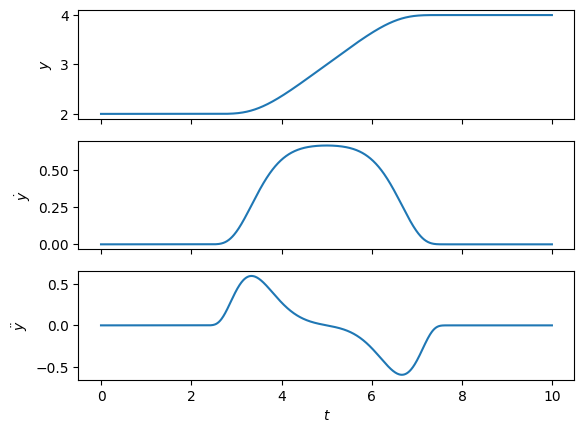

In [6]:
def plot_t_y(t, y):
    fig, ax = plt.subplots(3, 1, sharex=True)

    ax[0].plot(t, y[0, :])
    ax[0].set_ylabel("$y$")

    ax[1].plot(t, y[1, :])
    ax[1].set_ylabel("$\\dot y$")

    ax[2].plot(t, y[2, :])
    ax[2].set_ylabel("$\\ddot y$")
    ax[2].set_xlabel("$t$")


t = np.arange(0, 10, 0.01)
y = np.zeros([3, t.size])
#MyTrajGen = TrajGenProto(2, 8, 2, 4, 2)
#MyTrajGen = TrajGenPoly(2, 8, 2, 4, 2)
MyTrajGen = TrajGenTanh(2, 8, 2, 4, 1.1)

for i, t_val in enumerate(t):
    y[:, i] = MyTrajGen.eval(t_val, 2)

plot_t_y(t, y)

Das sieht erst einmal plausibel aus. Sind die Ableitungen aber wirklich korrekt? Dazu vergleichen wir mit der numerischen Differentiation:

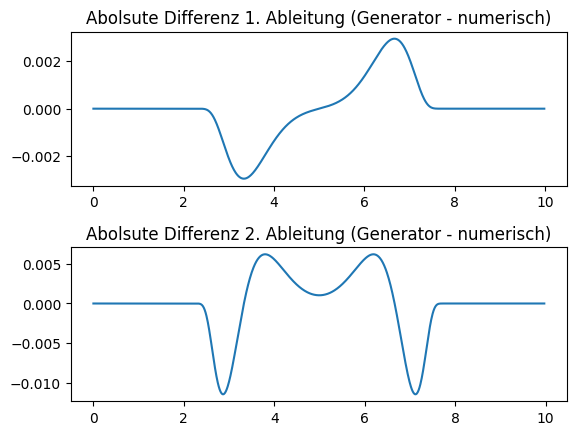

In [7]:
def verify_t_y(t, y):
    ydot_num = np.diff(y[0, :], n=1)/(t[1] - t[0])
    yddot_num = np.diff(y[0, :], n=2)/(t[1] - t[0])**2

    fig, ax = plt.subplots(2, 1)
    ax[0].plot(t[0:-1], y[1, 0:-1] - ydot_num)
    ax[0].set_title("Abolsute Differenz 1. Ableitung (Generator - numerisch)")
    ax[1].plot(t[0:-2], y[2, 0:-2] - yddot_num)
    ax[1].set_title("Abolsute Differenz 2. Ableitung (Generator - numerisch)")
    fig.subplots_adjust(hspace=0.4)


verify_t_y(t, y)

Das sieht auch gut aus. Wenn man die Differenz zwischen jeweils zwei Zeitpunkten in der Zelle oben reduziert, wird die Differenz hier noch kleiner, was auch auf eine korrekte Implementierung hindeutet.

## Test der eval_v-Methode

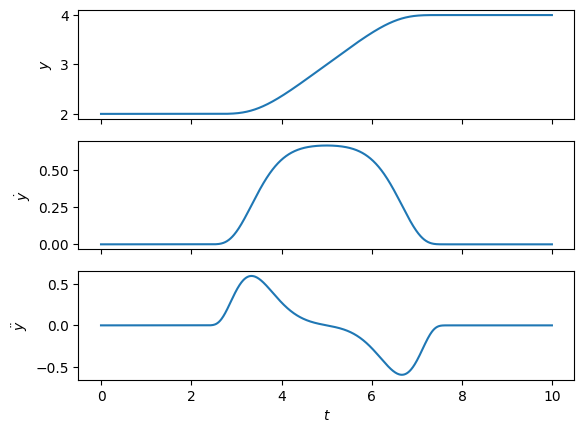

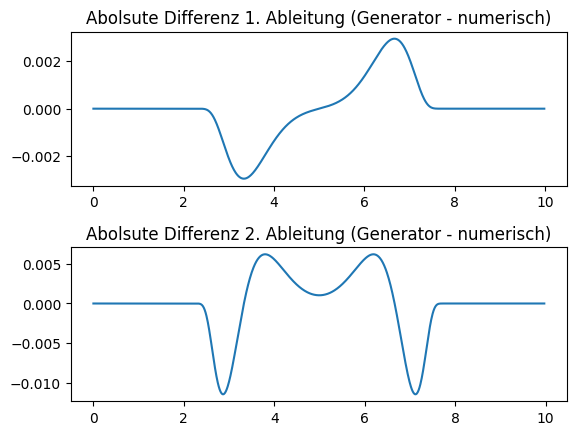

In [8]:
y = MyTrajGen.eval_v(t, 2)
plot_t_y(t, y)
verify_t_y(t, y)